In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

ds = pd.read_csv("D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/antwerp_ds_weather-data.csv", index_col=0)

In [3]:
#### Remove entries with less than 3 gateways #### 
columns = ds.columns
x = ds[columns[0:68]]  # Get basestations' RSS readings
c = (x == -200).astype(int).sum(axis=1) # counting the amount of not-receiving gateways per message
c = 68 - c  # counting the amount of receiving gateways per message
c = c.tolist()

# finding indices of messages with less than 3 receiving gateways, and dropping these messages from the dataset ds
indices = list()
for i in range(len(c)):
    element = c[i]
    if element <3:
        indices.append(i)  # appending all indices of messages with fewer than 3 receiving gateways

print(ds.shape) # size before...
ds = ds.drop(indices) # dropping all entries with fewer than 3 receiving gateways
print(ds.shape) # ... and size after the dropping


#### Dataset preparation for ML pipeline
columns = ds.columns
x1 = ds[columns[0:68]] #features (RSS receptions)
x2 = ds[columns[69:71]] # SF and HDOP
x3 = ds[columns[75:]] #weather data  
x = pd.concat([x1, x2, x3], axis=1)
y = ds[columns[71:73]] # target (locations)
random_state = 42


(123528, 109)
(114011, 109)


In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [ ]:
# Train, validation, test set splitting, (70%/15%/15%)
x_train, x_test_val, y_train, y_test_val = train_test_split(x_scaled.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)

# Save dataset splits to .csv files  
x_train_df = pd.DataFrame(x_train, columns=x.columns.values.tolist())
x_val_df = pd.DataFrame(x_val, columns=x.columns.values.tolist())
x_test_df = pd.DataFrame(x_test, columns=x.columns.values.tolist())
x_train_df.to_csv('files/x_train.csv', index=False)
x_val_df.to_csv('files/x_val.csv', index=False)
x_test_df.to_csv('files/x_test.csv', index=False)


y_train_df = pd.DataFrame(y_train, columns=y.columns.values.tolist())
y_val_df = pd.DataFrame(y_val, columns=y.columns.values.tolist())
y_test_df = pd.DataFrame(y_test, columns=y.columns.values.tolist())
y_train_df.to_csv('files/y_train.csv', index=False)
y_val_df.to_csv('files/y_val.csv', index=False)
y_test_df.to_csv('files/y_test.csv', index=False)

In [39]:
x.columns.values[70:].tolist()

['temperature_2m',
 'relative_humidity_2m',
 'dew_point_2m',
 'apparent_temperature',
 'precipitation',
 'rain',
 'snowfall',
 'snow_depth',
 'weather_code',
 'pressure_msl',
 'surface_pressure',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_mid',
 'cloud_cover_high',
 'et0_fao_evapotranspiration',
 'vapour_pressure_deficit',
 'wind_speed_10m',
 'wind_speed_100m',
 'wind_direction_10m',
 'wind_direction_100m',
 'wind_gusts_10m',
 'shortwave_radiation',
 'direct_radiation',
 'diffuse_radiation',
 'direct_normal_irradiance',
 'global_tilted_irradiance',
 'terrestrial_radiation',
 'shortwave_radiation_instant',
 'direct_radiation_instant',
 'diffuse_radiation_instant',
 'direct_normal_irradiance_instant',
 'global_tilted_irradiance_instant',
 'terrestrial_radiation_instant']

# plotting scaled weather data

import seaborn as sns
import matplotlib.pyplot as plt

x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)
x_weather = x_scaled_df.iloc[:, 70:]

x_weather.plot.density(subplots=True, layout=(-1, 2), figsize=(15, 60))

<Axes: title={'center': 'Unique values per feature'}>

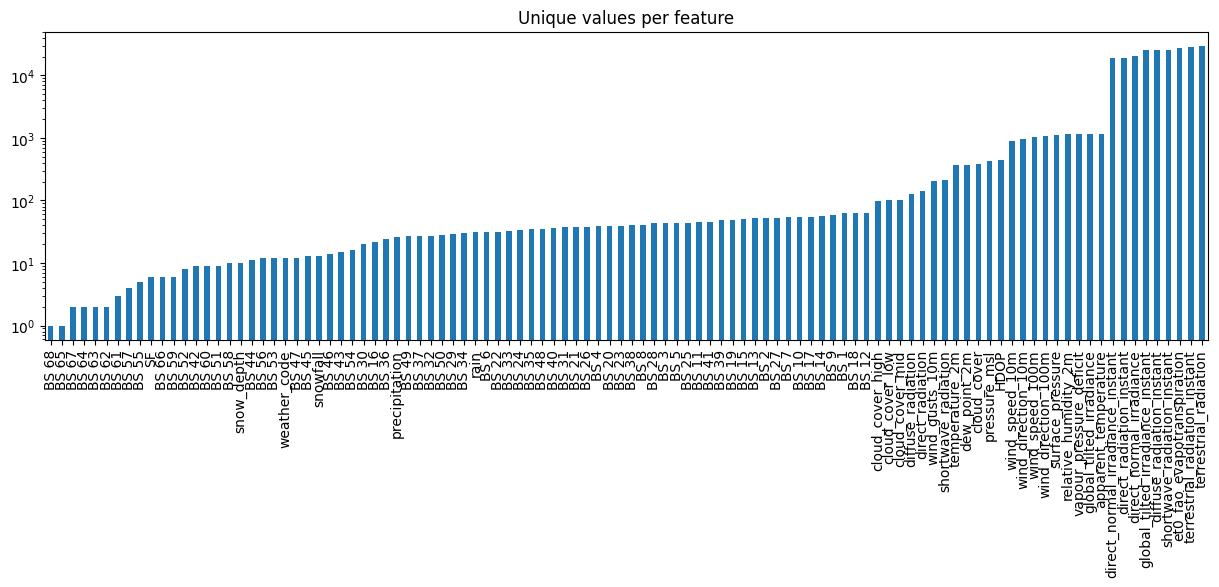

In [92]:
# For each numerical feature compute number of unique entries
unique_values = x_scaled_df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature")

In [6]:
# linear regression feature importance
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def feature_importance_calculator(model, x_scaled, y_column):
	# fit the model
	model.fit(x_scaled, y_column)
	model_name = type(model).__name__
	# get importance
	if model_name=='LinearRegression':
		importance = model.coef_
	elif model_name=='DecisionTreeRegressor' or model_name=='RandomForestRegressor' or model_name=='XGBRegressor':
		importance = model.feature_importances_
	elif model_name=='KNeighborsRegressor':
		# perform permutation importance
		results = permutation_importance(model, x_scaled, y_column, scoring='neg_mean_squared_error')
		importance = results.importances_mean
	# summarize feature importance
	for i,v in enumerate(importance):
		print(f'Feature: {i}, Score: {v:.5f}')
	# plot feature importance
	plt.bar([im for im in range(len(importance))], importance)
	plt.savefig(f'plots/feature_importance_{model_name}_{y_column.name}.png')
	plt.show()
	

# define the model
model = LinearRegression()
	
# feature_importance_calculator(model, x_scaled, y['Latitude'])
# feature_importance_calculator(model, x_scaled, y['Longitude'])

Feature: 0, Score: 0.0095202919291889
Feature: 1, Score: 0.44795627598256565
Feature: 2, Score: 0.004647438938451106
Feature: 3, Score: 0.018076082365671542
Feature: 4, Score: 0.11414796569554092
Feature: 5, Score: 0.005298026075032868
Feature: 6, Score: 0.0031230005981840313
Feature: 7, Score: 0.001310991812806557
Feature: 8, Score: 0.029218393902744173
Feature: 9, Score: 0.07979925677249809
Feature: 10, Score: 0.03918163670539232
Feature: 11, Score: 0.004538163763596749
Feature: 12, Score: 0.09910821279022355
Feature: 13, Score: 0.010548475805438298
Feature: 14, Score: 0.0019504383205533814
Feature: 15, Score: 0.0005112601180769928
Feature: 16, Score: 0.00689331192790356
Feature: 17, Score: 0.011415915434660215
Feature: 18, Score: 0.0030240357775156938
Feature: 19, Score: 0.015598602408811694
Feature: 20, Score: 0.00025692520929536833
Feature: 21, Score: 0.00178225042941588
Feature: 22, Score: 0.0013162240885901545
Feature: 23, Score: 0.00016879610397700106
Feature: 24, Score: 0.0096

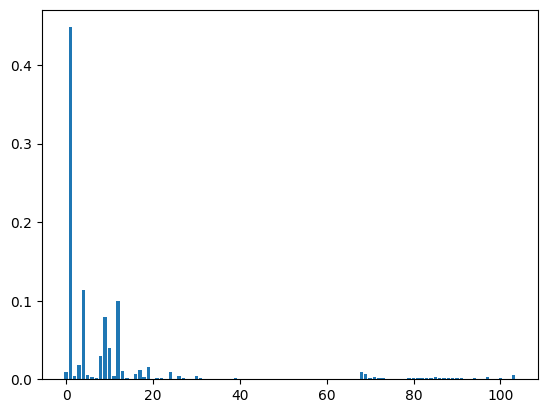

Feature: 0, Score: 0.015357105352234885
Feature: 1, Score: 0.052406727418437035
Feature: 2, Score: 0.0030603747025743926
Feature: 3, Score: 0.004803610517220074
Feature: 4, Score: 0.011182981572671032
Feature: 5, Score: 0.0012853493865809288
Feature: 6, Score: 0.13460188287008176
Feature: 7, Score: 0.054937398686660664
Feature: 8, Score: 0.041393145077240304
Feature: 9, Score: 0.028492988269361363
Feature: 10, Score: 0.025750934935099883
Feature: 11, Score: 0.012965574735939862
Feature: 12, Score: 0.007540713976914562
Feature: 13, Score: 0.019424798280737277
Feature: 14, Score: 0.21034200822705934
Feature: 15, Score: 0.0017221911528925602
Feature: 16, Score: 0.03391629780975854
Feature: 17, Score: 0.02216607066903861
Feature: 18, Score: 0.024917030976121014
Feature: 19, Score: 0.004622100769656124
Feature: 20, Score: 0.0014329448916184898
Feature: 21, Score: 0.0012148933571725956
Feature: 22, Score: 0.005129756718668942
Feature: 23, Score: 7.77273856299591e-05
Feature: 24, Score: 0.091

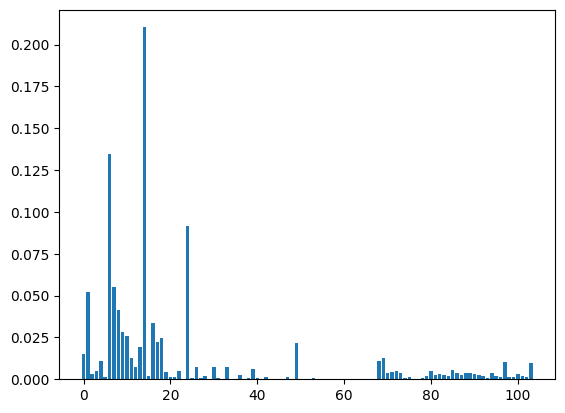

In [42]:
# DecisionTreeRegressor feature importance

from sklearn.tree import DecisionTreeRegressor

dr_model = DecisionTreeRegressor()

feature_importance_calculator(dr_model, x_scaled, y['Latitude'])
feature_importance_calculator(dr_model, x_scaled, y['Longitude'])

Feature: 0, Score: 0.009688635800457307
Feature: 1, Score: 0.4482507768899789
Feature: 2, Score: 0.004905855519738786
Feature: 3, Score: 0.01792479079764828
Feature: 4, Score: 0.1141599563845634
Feature: 5, Score: 0.006105258816624761
Feature: 6, Score: 0.002819077359294936
Feature: 7, Score: 0.0012349836461595137
Feature: 8, Score: 0.030243976111445713
Feature: 9, Score: 0.07915042084395281
Feature: 10, Score: 0.038254156546527106
Feature: 11, Score: 0.004210324944982342
Feature: 12, Score: 0.09899043976143142
Feature: 13, Score: 0.0108207899671395
Feature: 14, Score: 0.0019528860504444117
Feature: 15, Score: 0.0004256339176387245
Feature: 16, Score: 0.007148523009775651
Feature: 17, Score: 0.012117102974466474
Feature: 18, Score: 0.003052579349850305
Feature: 19, Score: 0.015635115755708657
Feature: 20, Score: 0.00022419197739784245
Feature: 21, Score: 0.0017144601072083534
Feature: 22, Score: 0.0013052452752364033
Feature: 23, Score: 0.0002093598246274868
Feature: 24, Score: 0.00858

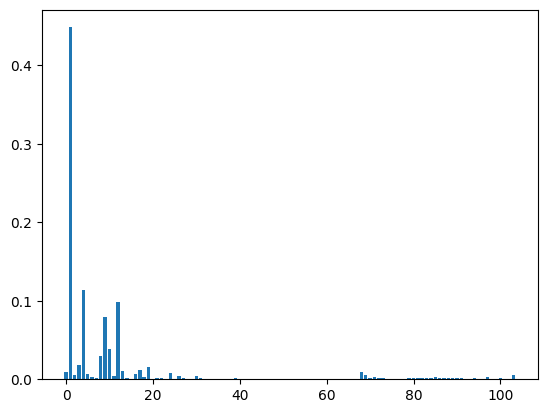

Feature: 0, Score: 0.015494786132028175
Feature: 1, Score: 0.04989638009919604
Feature: 2, Score: 0.0036100673435373186
Feature: 3, Score: 0.004780599241175537
Feature: 4, Score: 0.011066392168433754
Feature: 5, Score: 0.0014236629340488424
Feature: 6, Score: 0.13441099382487182
Feature: 7, Score: 0.054134191804636876
Feature: 8, Score: 0.04072413484714045
Feature: 9, Score: 0.02846900495816737
Feature: 10, Score: 0.025142555974613578
Feature: 11, Score: 0.012843012566291894
Feature: 12, Score: 0.007548652989437593
Feature: 13, Score: 0.01985923933758563
Feature: 14, Score: 0.2119620394066331
Feature: 15, Score: 0.0017166197779955254
Feature: 16, Score: 0.037390510990283274
Feature: 17, Score: 0.02136456161313668
Feature: 18, Score: 0.024607549914597553
Feature: 19, Score: 0.00463737909717041
Feature: 20, Score: 0.0014505423202280426
Feature: 21, Score: 0.0011713907284091431
Feature: 22, Score: 0.0047898191096121135
Feature: 23, Score: 8.819544033468021e-05
Feature: 24, Score: 0.091672

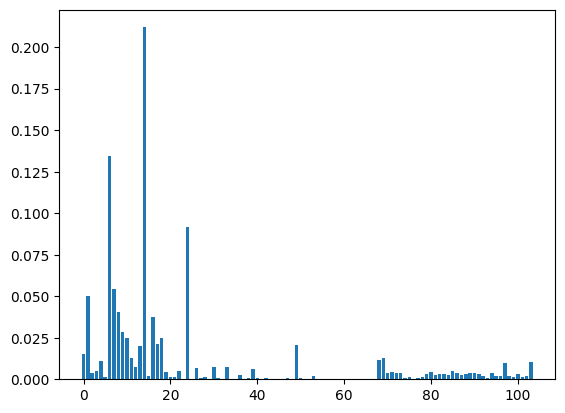

In [48]:
# RandomForestRegressor feature importance
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

feature_importance_calculator(rf_model, x_scaled, y['Latitude'])
feature_importance_calculator(rf_model, x_scaled, y['Longitude'])

Feature: 0, Score: 0.02474457025527954
Feature: 1, Score: 0.336209237575531
Feature: 2, Score: 0.010820196010172367
Feature: 3, Score: 0.031146550551056862
Feature: 4, Score: 0.0750819593667984
Feature: 5, Score: 0.013227719813585281
Feature: 6, Score: 0.0020751934498548508
Feature: 7, Score: 0.0016370519297197461
Feature: 8, Score: 0.019983787089586258
Feature: 9, Score: 0.11622818559408188
Feature: 10, Score: 0.02434333600103855
Feature: 11, Score: 0.008134678937494755
Feature: 12, Score: 0.0594986267387867
Feature: 13, Score: 0.005637289956212044
Feature: 14, Score: 0.004419147968292236
Feature: 15, Score: 0.0014714539283886552
Feature: 16, Score: 0.010353232733905315
Feature: 17, Score: 0.02758360654115677
Feature: 18, Score: 0.0027856251690536737
Feature: 19, Score: 0.009322880767285824
Feature: 20, Score: 0.000808322336524725
Feature: 21, Score: 0.008552184328436852
Feature: 22, Score: 0.0056297192350029945
Feature: 23, Score: 0.0029873934108763933
Feature: 24, Score: 0.032867666

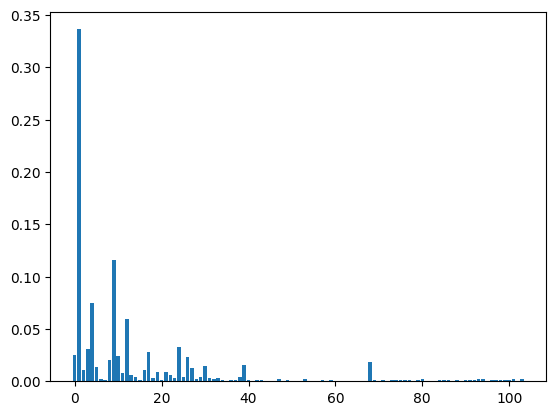

Feature: 0, Score: 0.00782648753374815
Feature: 1, Score: 0.03386194258928299
Feature: 2, Score: 0.005326126702129841
Feature: 3, Score: 0.004822851158678532
Feature: 4, Score: 0.014867139980196953
Feature: 5, Score: 0.0028196906205266714
Feature: 6, Score: 0.07735355198383331
Feature: 7, Score: 0.044975925236940384
Feature: 8, Score: 0.02009749412536621
Feature: 9, Score: 0.03849732503294945
Feature: 10, Score: 0.014621123671531677
Feature: 11, Score: 0.01315420214086771
Feature: 12, Score: 0.00342604611068964
Feature: 13, Score: 0.010798413306474686
Feature: 14, Score: 0.09523774683475494
Feature: 15, Score: 0.01719588413834572
Feature: 16, Score: 0.02374318428337574
Feature: 17, Score: 0.026133079081773758
Feature: 18, Score: 0.034771878272295
Feature: 19, Score: 0.021917950361967087
Feature: 20, Score: 0.0037271378096193075
Feature: 21, Score: 0.004100481513887644
Feature: 22, Score: 0.02592952735722065
Feature: 23, Score: 0.0028730372432619333
Feature: 24, Score: 0.085912078619003

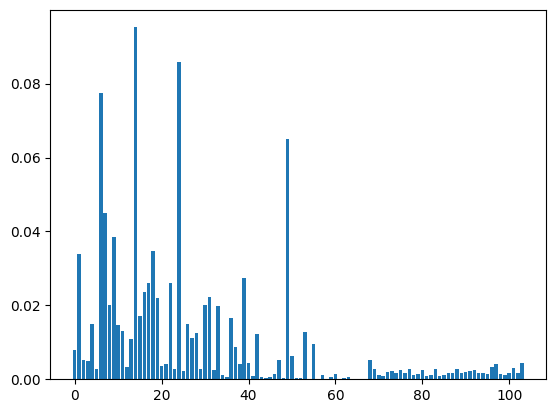

In [47]:
# XGBRegressor feature importance
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

feature_importance_calculator(xgb_model, x_scaled, y['Latitude'])
feature_importance_calculator(xgb_model, x_scaled, y['Longitude'])

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00001
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

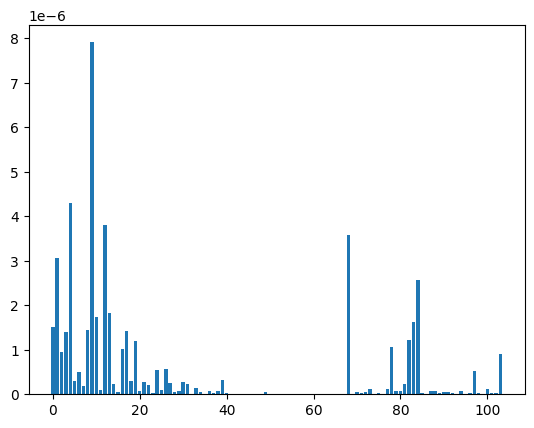

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00001
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00001
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

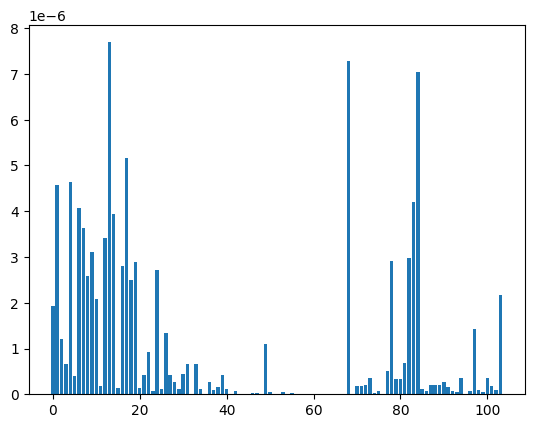

In [7]:
# Permutation feature importance

from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
feature_importance_calculator(knn_model, x_scaled, y['Latitude'])
feature_importance_calculator(knn_model, x_scaled, y['Longitude'])